<h3>Imports</h3>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json

<h3>Loading the data</h3>

In [2]:
# Load the data
file_path = 'sx-stackoverflow.txt'
df = pd.read_csv(file_path, sep=' ', header=None, names=['source_id', 'target_id', 'timestamp'])
print(df.head())

   source_id  target_id   timestamp
0          9          8  1217567877
1          1          1  1217573801
2         13          1  1217606247
3         17          1  1217617639
4         48          2  1217618182


<h2>Part I Questions</h2>
<h3>Question 1.1</h3>

In [3]:
# Find the minimum and maximum timestamps
tmin = df['timestamp'].min()
tmax = df['timestamp'].max()

# Define the number of partitions (N)
N = 10 

# Calculate the time intervals
delta_t = (tmax - tmin) / N

# Calculate the time instances {t0, t1, ..., tN}
time_instances = [tmin + j * delta_t for j in range(N + 1)]

# Print the results
print(f"tmin: {tmin}, tmax: {tmax}")
print(f"Time instances (boundaries): {time_instances}")


tmin: 1217567877, tmax: 1457273428
Time instances (boundaries): [1217567877.0, 1241538432.1, 1265508987.2, 1289479542.3, 1313450097.4, 1337420652.5, 1361391207.6, 1385361762.7, 1409332317.8, 1433302872.9, 1457273428.0]


<h3>Question 1.2</h3>

In [4]:
reduced = True # Run the code for the whole graph or a sample
edges_per_reduced_graph = 5000 # Number of samples for each time period in reduced mode

# Define a list to store the subgraphs
subgraphs = []

if not reduced:
    # Generate subgraphs for each time period
    for j in range(1, len(time_instances)):
        t_start = time_instances[j-1]
        t_end = time_instances[j]
        
        # Filter the DataFrame for edges in the current time period
        if j < N:
            df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] < t_end)]
        else:
            df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] <= t_end)]
        
        # Create a directed graph using NetworkX
        G = nx.Graph()
        
        # Add edges to the graph
        for _, row in df_sub.iterrows():
            G.add_edge(row['source_id'], row['target_id'])

        #Remove self loops
        G.remove_edges_from(nx.selfloop_edges(G))

        # Store the subgraph
        subgraphs.append(G)

        print(f"Subgraph {j} created. |V| = {len(G.nodes)}, |E| = {len(G.edges)}")

if reduced:
    for j in range(1, len(time_instances)):
        t_start = time_instances[j-1]
        t_end = time_instances[j]
        
        # Filter the DataFrame for edges in the current time period
        if j < N:
            df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] < t_end)]
        else:
            df_sub = df[(df['timestamp'] >= t_start) & (df['timestamp'] <= t_end)]
        
        # If the DataFrame has more than edges_per_reduced_graph rows, sample edges_per_reduced_graph edges
        if len(df_sub) > edges_per_reduced_graph:
            df_sub_limited = df_sub.sample(n=edges_per_reduced_graph)
        else:
            df_sub_limited = df_sub  # If less than edges_per_reduced_graph edges, keep all edges
        
        # Create a graph using NetworkX
        G = nx.Graph()
        
        # Add edges to the graph
        for _, row in df_sub_limited.iterrows():
            G.add_edge(row['source_id'], row['target_id'])

        #Remove self loops
        G.remove_edges_from(nx.selfloop_edges(G))

        # Store the subgraph
        subgraphs.append(G)

        print(f"Subgraph {j} created. |V| = {len(G.nodes)}, |E| = {len(G.edges)}")

Subgraph 1 created. |V| = 5266, |E| = 4328
Subgraph 2 created. |V| = 6194, |E| = 4086
Subgraph 3 created. |V| = 6676, |E| = 4014
Subgraph 4 created. |V| = 7139, |E| = 3930
Subgraph 5 created. |V| = 7363, |E| = 3808
Subgraph 6 created. |V| = 7587, |E| = 3752
Subgraph 7 created. |V| = 7736, |E| = 3758
Subgraph 8 created. |V| = 7790, |E| = 3682
Subgraph 9 created. |V| = 7873, |E| = 3725
Subgraph 10 created. |V| = 7797, |E| = 3657


<h3>Question 1.3</h3>

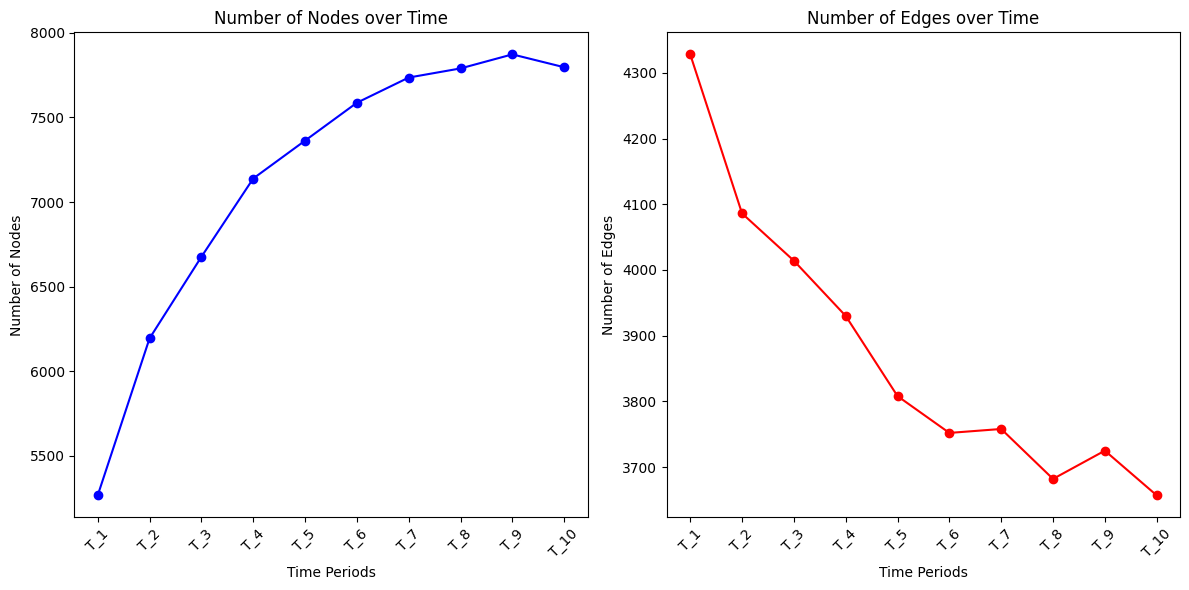

In [5]:
subgraphs_node_num = []
subgraphs_edge_num = []
time_periods = [f"T_{i}" for i in range(1, N+1)]

for subgraph in subgraphs:
    subgraphs_node_num.append(len(subgraph.nodes()))
    subgraphs_edge_num.append(len(subgraph.edges()))

# Plotting
plt.figure(figsize=(12, 6))

# Plot number of nodes
plt.subplot(1, 2, 1)
plt.plot(time_periods, subgraphs_node_num, marker='o', linestyle='-', color='b')
plt.xlabel('Time Periods')
plt.ylabel('Number of Nodes')
plt.title('Number of Nodes over Time')
plt.xticks(rotation=45)

# Plot number of edges
plt.subplot(1, 2, 2)
plt.plot(time_periods, subgraphs_edge_num, marker='o', linestyle='-', color='r')
plt.xlabel('Time Periods')
plt.ylabel('Number of Edges')
plt.title('Number of Edges over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<h3>Question 1.4</h3>

In [6]:
centrality_measures = []
index = 1
for G in subgraphs:
    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G)
    with open(f"centralities/degree{index}.json", "w") as f:
        json.dump({str(key): value for key, value in degree_centrality.items()}, f)

    closeness_centrality = nx.closeness_centrality(G)
    with open(f"centralities/closeness{index}.json", "w") as f:
        json.dump({str(key): value for key, value in closeness_centrality.items()}, f)
    
    betweenness_centrality = nx.betweenness_centrality(G)
    with open(f"centralities/betweenness{index}.json", "w") as f:
        json.dump({str(key): value for key, value in betweenness_centrality.items()}, f)

    # Try computing eigenvector centrality, handle exceptions
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G)
        with open(f"centralities/eigenvector{index}.json", "w") as f:
            json.dump({str(key): value for key, value in eigenvector_centrality.items()}, f)
    except nx.PowerIterationFailedConvergence as e:
        print(f"Warning: Eigenvector centrality did not converge for subgraph {index}.")
        eigenvector_centrality = {node: None for node in G.nodes()}

    # Try computing Katz centrality, handle exceptions
    try:
        katz_centrality = nx.katz_centrality(G)
        with open(f"centralities/katz{index}.json", "w") as f:
            json.dump({str(key): value for key, value in katz_centrality.items()}, f)
    except nx.PowerIterationFailedConvergence as e:
        print(f"Warning: Katz centrality did not converge for subgraph {index}.")
        katz_centrality = {node: None for node in G.nodes()}

    # Store centrality measures
    centrality_measures.append({
        'degree': list(degree_centrality.values()),
        'closeness': list(closeness_centrality.values()),
        'betweenness': list(betweenness_centrality.values()),
        'eigenvector': list(eigenvector_centrality.values()),
        'katz': list(katz_centrality.values())
    })
    print(f"Centralities computed for T_{index}")
    index += 1

Centralities computed for T_1
Centralities computed for T_2
Centralities computed for T_3
Centralities computed for T_4
Centralities computed for T_5
Centralities computed for T_6
Centralities computed for T_7
Centralities computed for T_8
Centralities computed for T_9
Centralities computed for T_10


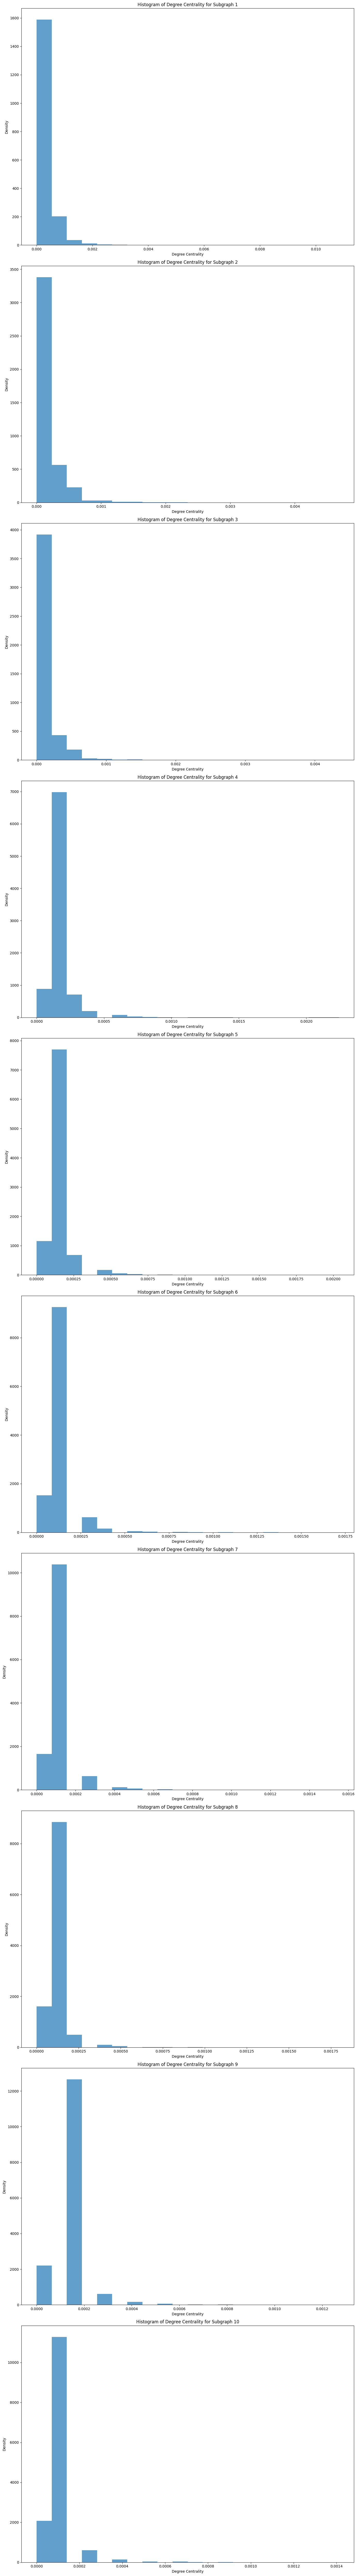

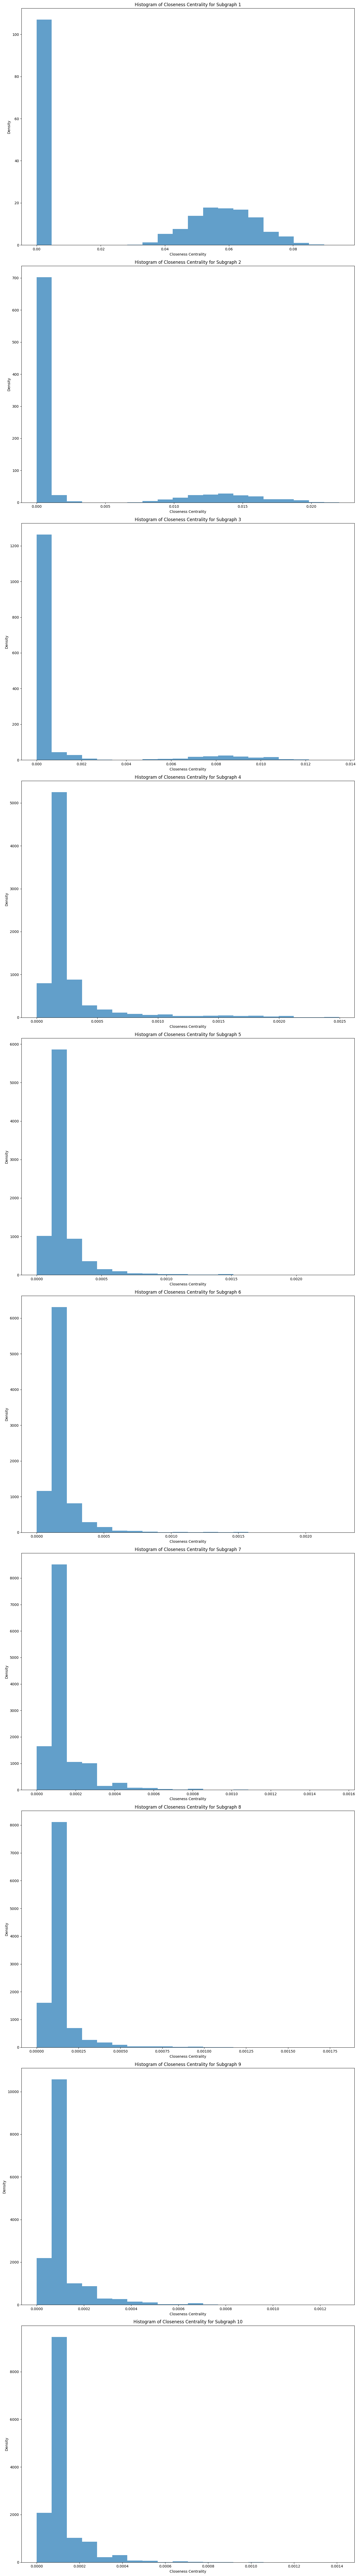

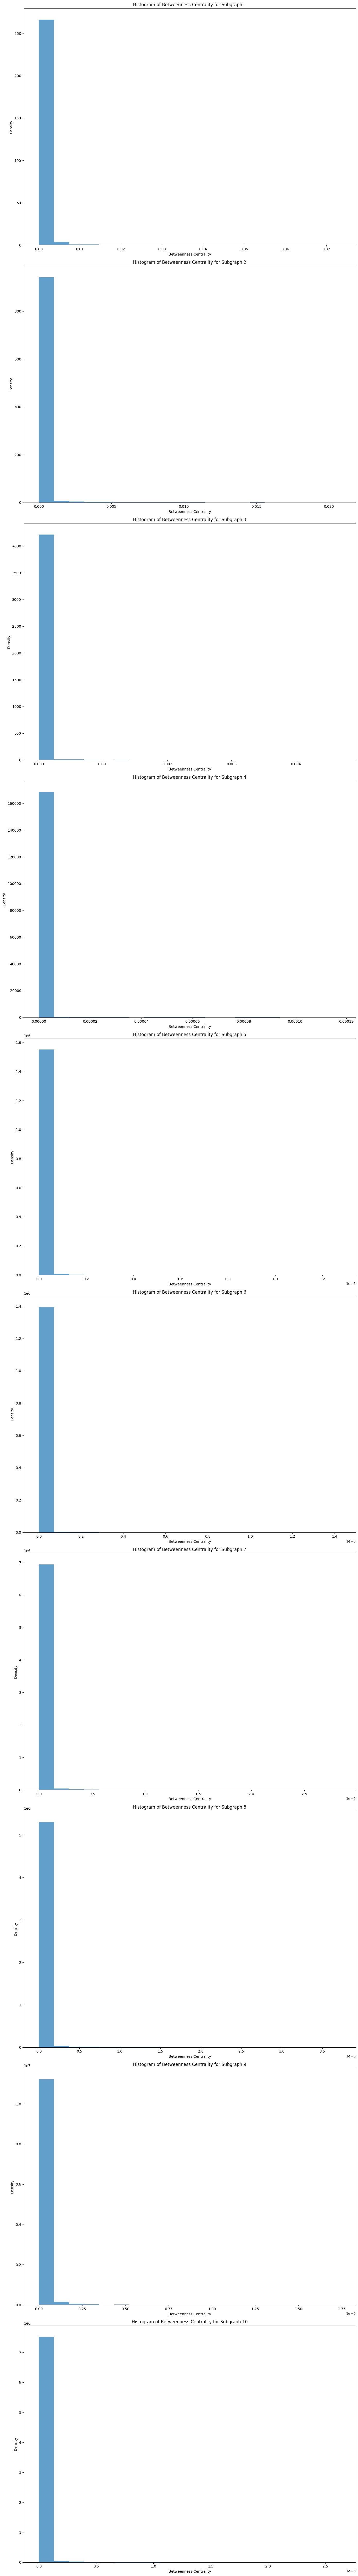

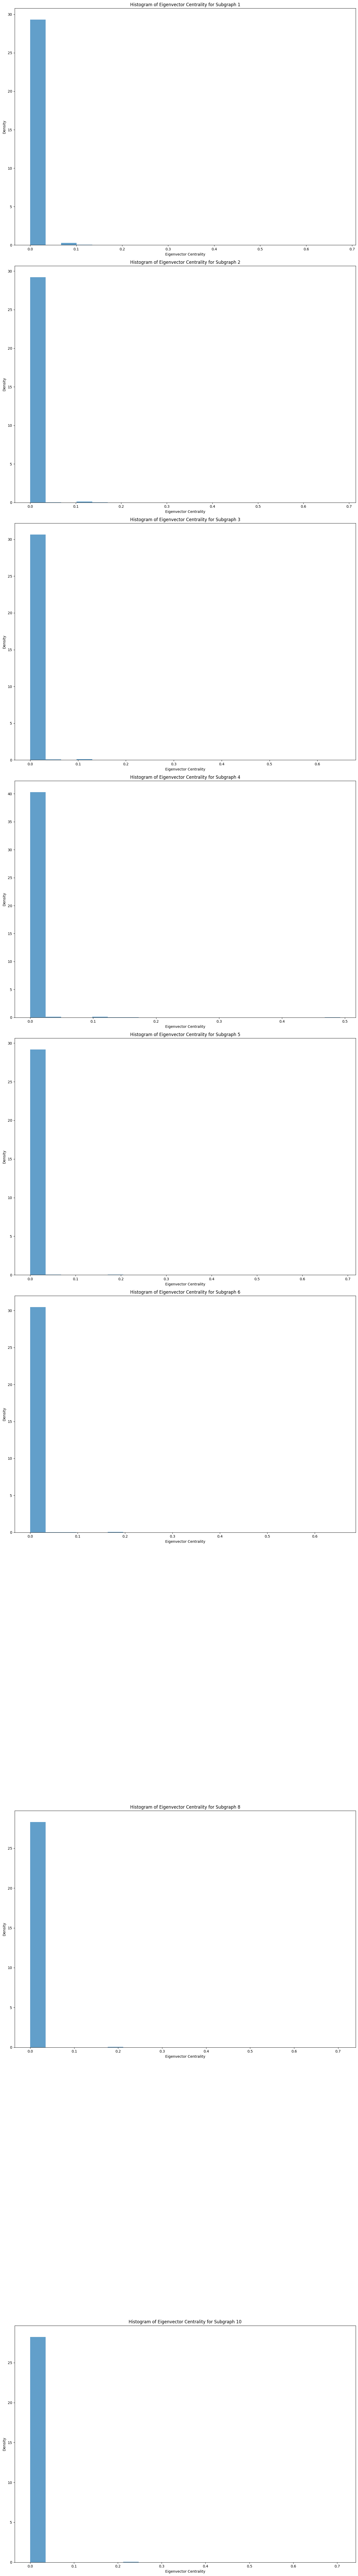

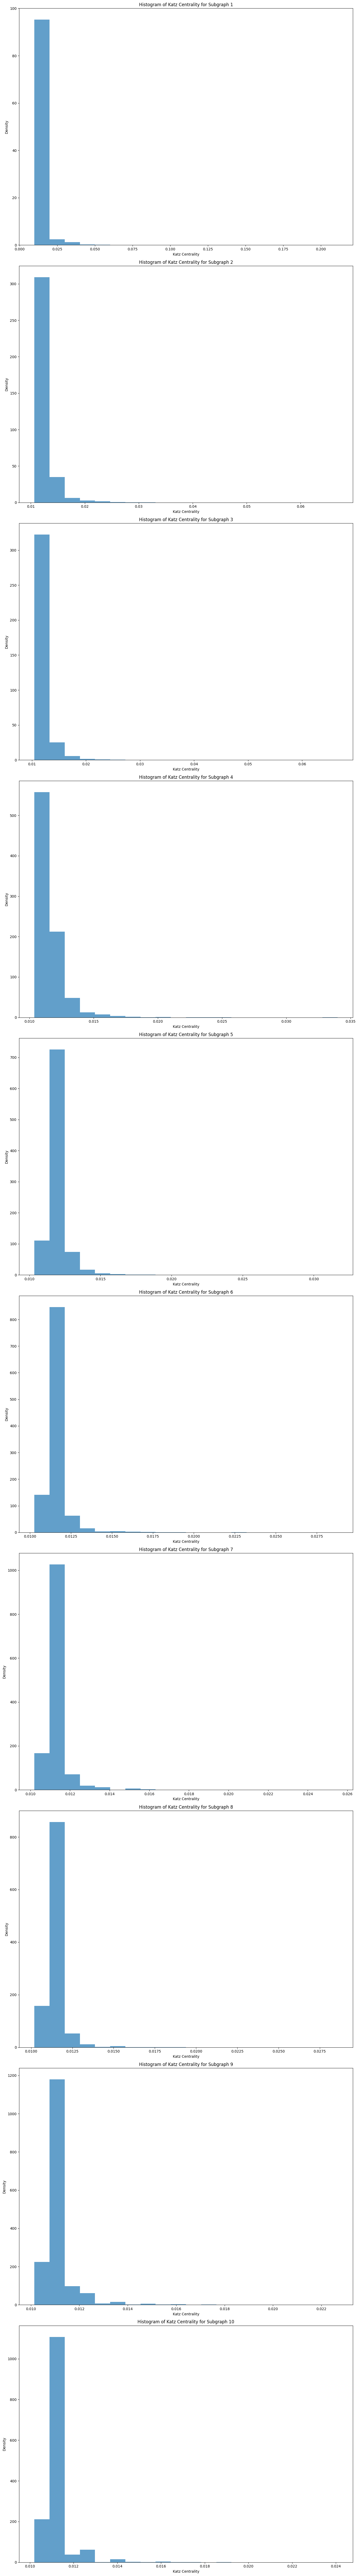

In [7]:
# Plot histograms for centrality measures
measures = ['degree', 'closeness', 'betweenness', 'eigenvector', 'katz']
for measure in measures:
    num_subgraphs = len(centrality_measures)
    
    # Dynamically adjust the figure size based on number of subgraphs
    plt.figure(figsize=(14, 10 * num_subgraphs))  # Set height based on subgraphs
    
    # Loop over subgraphs
    for i, measure_values in enumerate([cm[measure] for cm in centrality_measures]):
        # Filter out None values
        measure_values_filtered = [val for val in measure_values if val is not None]
        # Only plot if there are valid values to plot
        if len(measure_values_filtered) > 0:
            plt.subplot(num_subgraphs, 1, i+1)  # Create a subplot for each subgraph
            plt.hist(measure_values_filtered, bins=20, density=True, alpha=0.7)
            plt.xlabel(f'{measure.capitalize()} Centrality')
            plt.ylabel('Density')
            plt.title(f'Histogram of {measure.capitalize()} Centrality for Subgraph {i+1}')
    
    plt.tight_layout()
    plt.show()

<h2>Part II Questions</h2>
<h3>Question 2.1</h3>

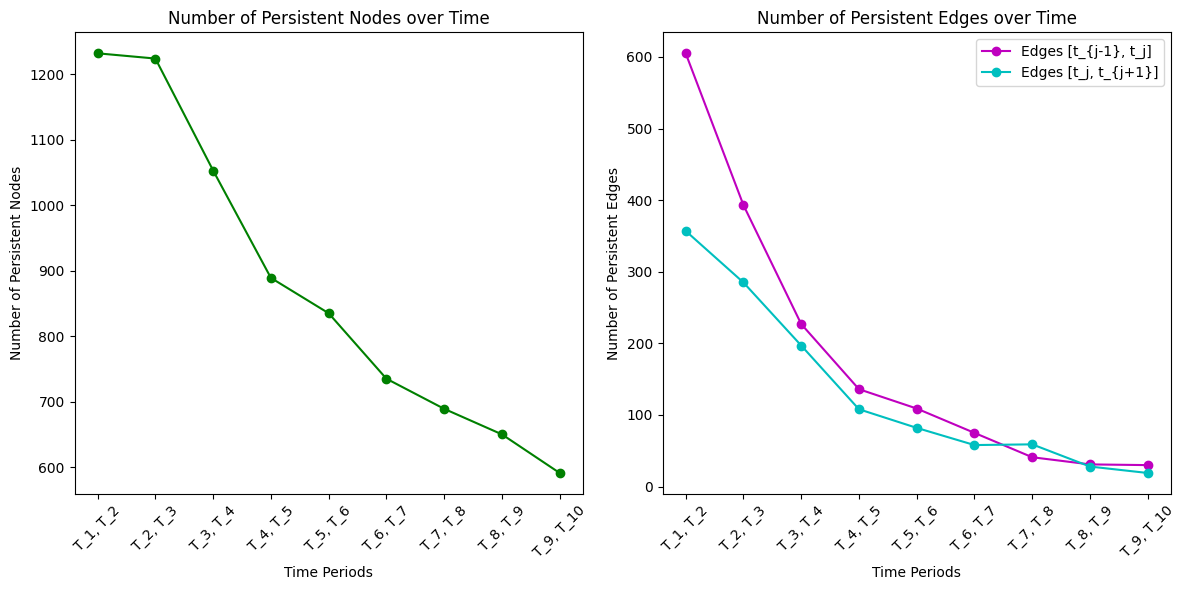

In [8]:
# Prepare lists for persistent nodes and edges
persistent_nodes = []
persistent_edges_prev = []
persistent_edges_next = []

persistent_nodes_num = []
persistent_edges_prev_num = []
persistent_edges_next_num = []

# Compute persistent nodes and edges
for j in range(len(subgraphs) - 1):
    # Get nodes and edges for periods [T_{j-1}, T_j] and [T_j, T_{j+1}]
    V_prev = set(subgraphs[j].nodes())
    V_next = set(subgraphs[j+1].nodes())

    V_star = V_prev.intersection(V_next)
    
    E_prev = set(subgraphs[j].edges())
    E_next = set(subgraphs[j+1].edges())
    
    E_star_prev = {(u, v) for (u, v) in E_prev if u in V_star and v in V_star}
    E_star_next = {(u, v) for (u, v) in E_next if u in V_star and v in V_star}
    
    persistent_nodes.append(V_star)
    persistent_edges_prev.append(E_star_prev)
    persistent_edges_next.append(E_star_next)

    persistent_nodes_num.append(len(V_star))
    persistent_edges_prev_num.append(len(E_star_prev))
    persistent_edges_next_num.append(len(E_star_next))

# Prepare time_periods for plotting
time_periods = [f"T_{i + 1}, T_{i + 2}" for i in range(len(subgraphs) - 1)]

# Plot persistent nodes and edges
plt.figure(figsize=(12, 6))

# Plot number of persistent nodes
plt.subplot(1, 2, 1)
plt.plot(time_periods, persistent_nodes_num, marker='o', linestyle='-', color='g')
plt.xlabel('Time Periods')
plt.ylabel('Number of Persistent Nodes')
plt.title('Number of Persistent Nodes over Time')
plt.xticks(rotation=45)

# Plot number of persistent edges
plt.subplot(1, 2, 2)
plt.plot(time_periods, persistent_edges_prev_num, marker='o', linestyle='-', color='m', label='Edges [t_{j-1}, t_j]')
plt.plot(time_periods, persistent_edges_next_num, marker='o', linestyle='-', color='c', label='Edges [t_j, t_{j+1}]')
plt.xlabel('Time Periods')
plt.ylabel('Number of Persistent Edges')
plt.title('Number of Persistent Edges over Time')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

<h3>Question 2.2</h3>

In [ ]:
# Helper function to convert matrix keys to strings for JSON compatibility
def stringify_keys(matrix):
    return {str(key): value for key, value in matrix.items()}

# Placeholder for similarity matrices
similarities = {
    "SGD" : {
        "prev": {},
        "next": {}
    },
    "SCN" : {
        "prev": {},
        "next": {}
    },
    "SJC" : {
        "prev": {},
        "next": {}
    },
    "SA" : {
        "prev": {},
        "next": {}
    },
    "SPA" : {
        "prev": {},
        "next": {}
    }
}


# Iterate through the graph pairs for each time period
for j in range(len(persistent_nodes)):
    V_star = persistent_nodes[j]
    G_prev = nx.Graph()
    G_prev.add_edges_from(persistent_edges_prev[j])
    G_next = nx.Graph()
    G_next.add_edges_from(persistent_edges_next[j])

    # Initialize similarity matrices for each measure
    similarities["SGD"]["prev"][j] = {}
    similarities["SCN"]["prev"][j] = {}
    similarities["SJC"]["prev"][j] = {}
    similarities["SA"]["prev"][j] = {}
    similarities["SPA"]["prev"][j] = {}

    similarities["SGD"]["next"][j] = {}
    similarities["SCN"]["next"][j] = {}
    similarities["SJC"]["next"][j] = {}
    similarities["SA"]["next"][j] = {}
    similarities["SPA"]["next"][j] = {}

    # Compute the similarity for every pair of persistent nodes (u, v)
    for u in V_star:
        for v in V_star:
            if u != v:
                # SGD: Shortest path distance
                try:
                    similarities["SGD"]["prev"][j][(u, v)] = 1 / nx.shortest_path_length(G_prev, u, v)
                except:
                    pass
                try:
                    similarities["SGD"]["next"][j][(u, v)] = 1 / nx.shortest_path_length(G_prev, u, v)
                except:
                    pass
                
                # SCN: Common neighbors squared
                try:
                    similarities["SCN"]["prev"][j][(u, v)] = len(list(nx.common_neighbors(G_prev, u, v)))
                except:
                    pass
                try:
                    similarities["SCN"]["next"][j][(u, v)] = len(list(nx.common_neighbors(G_prev, u, v)))
                except:
                    pass

                #SJC: Jaccards Coe cient
                try:
                    for u, v, p in nx.jaccard_coefficient(G_prev, [(u, v)]):
                        similarities["SJC"]["prev"][j][(u, v)] = p
                except:
                    pass
                try:
                    for u, v, p in nx.jaccard_coefficient(G_next, [(u, v)]):
                        similarities["SJC"]["next"][j][(u, v)] = p
                except:
                    pass
                
                # SA: Adamic/Adar score
                try:
                    for u, v, p in nx.adamic_adar_index(G_prev, [(u, v)]):
                        similarities["SA"]["prev"][j][(u, v)] = p
                except:
                    pass
                try:
                    for u, v, p in nx.adamic_adar_index(G_next, [(u, v)]):
                        similarities["SA"]["next"][j][(u, v)] = p
                except:
                    pass

                # SPA: Preferential attachment (degree product)
                try:
                    for u, v, p in nx.preferential_attachment(G_prev, [(u, v)]):
                        similarities["SPA"]["prev"][j][(u, v)] = p
                except:
                    pass
                try:
                    for u, v, p in nx.preferential_attachment(G_next, [(u, v)]):
                        similarities["SPA"]["next"][j][(u, v)] = p
                except:
                    pass


    print("Similarities computed for", j) 

with open("similarities/SGD_matrix_prev.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SGD"]["prev"][j]) for j in similarities["SGD"]["prev"]}, f)
with open("similarities/SCN_matrix_prev.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SCN"]["prev"][j]) for j in similarities["SCN"]["prev"]}, f)
with open("similarities/SJC_matrix_prev.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SJC"]["prev"][j]) for j in similarities["SJC"]["prev"]}, f)
with open("similarities/SA_matrix_prev.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SA"]["prev"][j]) for j in similarities["SA"]["prev"]}, f)
with open("similarities/SPA_matrix_prev.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SPA"]["prev"][j]) for j in similarities["SPA"]["prev"]}, f)

with open("similarities/SGD_matrix_next.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SGD"]["next"][j]) for j in similarities["SGD"]["next"]}, f)
with open("similarities/SCN_matrix_next.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SCN"]["next"][j]) for j in similarities["SCN"]["next"]}, f)
with open("similarities/SJC_matrix_next.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SJC"]["next"][j]) for j in similarities["SJC"]["next"]}, f)
with open("similarities/SA_matrix_next.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SA"]["next"][j]) for j in similarities["SA"]["next"]}, f)
with open("similarities/SPA_matrix_next.json", "w") as f:
    json.dump({j: stringify_keys(similarities["SPA"]["next"][j]) for j in similarities["SPA"]["next"]}, f)

print("Matrices saved to files.")

Similarities computed for 0
Similarities computed for 1
Similarities computed for 2
Similarities computed for 3
Similarities computed for 4
Similarities computed for 5
Similarities computed for 6
Similarities computed for 7
Similarities computed for 8
Matrices saved to files.


<h2>Part III Questions</h2>

In [15]:
def calculate_accuracy(pred_edges, actual_edges, all_possible_edges):
    tp = len(pred_edges & actual_edges)
    tpr = tp / len(actual_edges) if actual_edges else 0
    
    tn = len(all_possible_edges - pred_edges - actual_edges)
    tnr = tn / (len(all_possible_edges) - len(actual_edges)) if len(all_possible_edges) > len(actual_edges) else 0
    
    lamda = len(actual_edges) / len(all_possible_edges) if all_possible_edges else 0
    return lamda * tpr + (1 - lamda) * tnr

# Function to determine optimal range R*X for a given similarity measure
def optimize_range(similarity_matrix_prev, similarity_matrix_next, training_edges, actual_edges, all_possible_edges):
    best_accuracy = 0
    best_ranges = []
    training_similarities = {t: similarity_matrix_prev.get(t, None) for t in training_edges if similarity_matrix_prev.get(t, None) is not None} 

    if not training_similarities:
        return best_ranges, best_accuracy

    min_score, max_score = min(training_similarities.values()), max(training_similarities.values())

    for lower_bound in np.linspace(min_score, max_score, num=20):
        for upper_bound in np.linspace(lower_bound, max_score, num=20):
            pred_edges = {edge for edge, score in similarity_matrix_next.items() if lower_bound <= score <= upper_bound}
            accuracy = calculate_accuracy(pred_edges, actual_edges, all_possible_edges)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_ranges = [(lower_bound, upper_bound)]

    return best_ranges, best_accuracy

# Example setup for training on each similarity measure for each period
optimal_ranges = {}
training_accuracies = {}
testing_accuracies = {}
for measure, similarity_matrices in similarities.items():
    optimal_ranges[measure] = {}
    training_accuracies[measure] = {}
    testing_accuracies[measure] = {}
    for period in range(N - 1):
        training_edges = persistent_edges_prev[period]  # Training set
        actual_edges = persistent_edges_next[period]  # Testing set
        all_possible_edges = {(u, v) for u in persistent_nodes[period] for v in persistent_nodes[period] if u != v}

        # Optimize range for current similarity measure
        optimal_range, accuracy = optimize_range(similarity_matrices['prev'][period], similarity_matrices['next'][period], training_edges, actual_edges, all_possible_edges)
        optimal_ranges[measure][period] = {'range': optimal_range, 'accuracy': accuracy}
        training_accuracies[measure][period] = {'accuracy': accuracy}
        print(f"Optimal range for {measure} in period {period}: {optimal_range} with accuracy {accuracy}")

        # Evaluate testing accuracy using the optimal range found
        pred_edges_test = {edge for edge, score in similarity_matrices['next'][period].items() if optimal_range[0][0] <= score <= optimal_range[0][1]}
        test_accuracy = calculate_accuracy(pred_edges_test, actual_edges, all_possible_edges)
        testing_accuracies[measure][period] = {'accuracy': test_accuracy}
        print(f"Testing accuracy for {measure} in period {period}: {test_accuracy}")

Optimal range for SGD in period 0: [(1.0, 1.0)] with accuracy 0.9989733560509353
Testing accuracy for SGD in period 0: 0.9989733560509353
Optimal range for SGD in period 1: [(1.0, 1.0)] with accuracy 0.9992885543424238
Testing accuracy for SGD in period 1: 0.9992885543424238
Optimal range for SGD in period 2: [(1.0, 1.0)] with accuracy 0.9994141309096949
Testing accuracy for SGD in period 2: 0.9994141309096949
Optimal range for SGD in period 3: [(1.0, 1.0)] with accuracy 0.9995237081851256
Testing accuracy for SGD in period 3: 0.9995237081851256
Optimal range for SGD in period 4: [(1.0, 1.0)] with accuracy 0.9995720788638549
Testing accuracy for SGD in period 4: 0.9995720788638549
Optimal range for SGD in period 5: [(1.0, 1.0)] with accuracy 0.9996181578898589
Testing accuracy for SGD in period 5: 0.9996181578898589
Optimal range for SGD in period 6: [(1.0, 1.0)] with accuracy 0.9997025517264658
Testing accuracy for SGD in period 6: 0.9997025517264658
Optimal range for SGD in period 7:

In [23]:
max_training_accuracies = {}
for measure, periods in training_accuracies.items():
    max_accuracy = max(periods.values(), key=lambda x: x['accuracy'])  # Find the period with max accuracy
    max_training_accuracies[measure] = max_accuracy['accuracy']

max_testing_accuracies = {}
for measure, periods in testing_accuracies.items():
    max_accuracy = max(periods.values(), key=lambda x: x['accuracy'])  # Find the period with max accuracy
    max_testing_accuracies[measure] = max_accuracy['accuracy']


# Sort the measures by accuracy in descending order
sorted_max_training_accuracies = sorted(max_training_accuracies.items(), key=lambda x: x[1], reverse=True)
sorted_max_testing_accuracies = sorted(max_testing_accuracies.items(), key=lambda x: x[1], reverse=True)

# Print the rankings
print("Ranking of Measures by Maximum Training Accuracy:")
for rank, (measure, accuracy) in enumerate(sorted_max_training_accuracies, start=1):
    print(f"Rank {rank}: {measure} with accuracy {accuracy:.6f}")

print("\nRanking of Measures by Maximum Testing Accuracy:")
for rank, (measure, accuracy) in enumerate(sorted_max_testing_accuracies, start=1):
    print(f"Rank {rank}: {measure} with accuracy {accuracy:.6f}")

Ranking of Measures by Maximum Training Accuracy:
Rank 1: SPA with accuracy 0.999946
Rank 2: SCN with accuracy 0.999822
Rank 3: SJC with accuracy 0.999822
Rank 4: SA with accuracy 0.999822
Rank 5: SGD with accuracy 0.999787

Ranking of Measures by Maximum Testing Accuracy:
Rank 1: SPA with accuracy 0.999946
Rank 2: SCN with accuracy 0.999822
Rank 3: SJC with accuracy 0.999822
Rank 4: SA with accuracy 0.999822
Rank 5: SGD with accuracy 0.999787
